# WiDS Datathon 2026 EDA: Kaylee

## Basic Dataset

In [10]:
import pandas as pd

# Load data and get shapes of datasets
print("=" * 80)
print("LOADING DATA & GETTING DATASET SHAPES")
print("=" * 80)
train = pd.read_csv('C:/Users/kayle/WIDS-Datathon-2026/WiDSWorldWide_GlobalDathon26/train.csv')
test = pd.read_csv('C:/Users/kayle/WIDS-Datathon-2026/WiDSWorldWide_GlobalDathon26/test.csv')
metadata = pd.read_csv('C:/Users/kayle/WIDS-Datathon-2026/WiDSWorldWide_GlobalDathon26/metaData.csv')

# shape and excerpt of data sets 
print(f"\nTrain shape: {train.shape}")
print(f"\nTraining data first five rows:")
print(train.head())
print(f"Test shape: {test.shape}")

LOADING DATA & GETTING DATASET SHAPES

Train shape: (221, 37)

Training data first five rows:
   event_id  num_perimeters_0_5h  dt_first_last_0_5h  \
0  10892457                    3            4.265188   
1  11757157                    2            1.169918   
2  11945086                    4            4.777526   
3  12044083                    1            0.000000   
4  12052347                    2            4.975273   

   low_temporal_resolution_0_5h  area_first_ha  area_growth_abs_0_5h  \
0                             0      79.696304              2.875935   
1                             0       8.946749              0.000000   
2                             0     106.482638              0.000000   
3                             1      67.631125              0.000000   
4                             0      35.632874              0.000000   

   area_growth_rel_0_5h  area_growth_rate_ha_per_h  log1p_area_first  \
0              0.036086                   0.674281          4.39

In [11]:
# More in depth, basic overview of data
target = 'event'
time_target = 'time_to_hit_hours'
id_col = 'event_id'
feature_cols = [col for col in train.columns if col not in [id_col, target, time_target]]

print(f"\n{'='*80}")
print("DATA SUMMARY")
print(f"{'='*80}")
print(f"Total features: {len(feature_cols)}")
print(f"Target distribution:")
print(f"  - Event=0 (Censored): {(train[target]==0).sum()} ({(train[target]==0).mean()*100:.1f}%)")
print(f"  - Event=1 (Hit):      {(train[target]==1).sum()} ({(train[target]==1).mean()*100:.1f}%)")

print(f"\nTime to hit statistics:")
print(f"  - Overall range: [{train[time_target].min():.1f}, {train[time_target].max():.1f}] hours")
hits_only = train[train[target] == 1]
print(f"  - For hits (event=1): Mean={hits_only[time_target].mean():.1f}h, Median={hits_only[time_target].median():.1f}h")

# Check for missing values
missing = train[feature_cols].isnull().sum()
if missing.sum() == 0:
    print(f"\n No missing values detected!")
else:
    print(f"\n Missing values found in {(missing > 0).sum()} features")



DATA SUMMARY
Total features: 34
Target distribution:
  - Event=0 (Censored): 152 (68.8%)
  - Event=1 (Hit):      69 (31.2%)

Time to hit statistics:
  - Overall range: [0.0, 67.0] hours
  - For hits (event=1): Mean=10.0h, Median=3.5h

 No missing values detected!


There are ~69% of the data points in the training set that are a censored event, and ~31% that the fire hits. The range provided for the data is 72 hours, but no data is measured that hits past 67 hours. The average time in the event of fire hitting is 10 hours after first obsservation, while the median is much quicker at 3.5 hours. No missing values in the dataset.

## Feature Exploration

In [12]:
# using metadata to map features by type 
category_map = dict(zip(metadata['column'], metadata['category']))
feature_categories = {}
for col in feature_cols:
    cat = category_map.get(col, 'unknown')
    if cat not in feature_categories:
        feature_categories[cat] = []
    feature_categories[cat].append(col)

print(f"\n{'='*80}")
print("FEATURES BY CATEGORY")
print(f"{'='*80}")
for cat, cols in sorted(feature_categories.items()):
    print(f"\n{cat.upper()} ({len(cols)} features):")
    for col in cols[:5]:  # Show first 5
        print(f"  - {col}")
    if len(cols) > 5:
        print(f"  ... and {len(cols)-5} more")


FEATURES BY CATEGORY

CENTROID_KINEMATICS (5 features):
  - centroid_displacement_m
  - centroid_speed_m_per_h
  - spread_bearing_deg
  - spread_bearing_sin
  - spread_bearing_cos

DIRECTIONALITY (4 features):
  - alignment_cos
  - alignment_abs
  - cross_track_component
  - along_track_speed

DISTANCE (9 features):
  - dist_min_ci_0_5h
  - dist_std_ci_0_5h
  - dist_change_ci_0_5h
  - dist_slope_ci_0_5h
  - closing_speed_m_per_h
  ... and 4 more

GROWTH (10 features):
  - area_first_ha
  - area_growth_abs_0_5h
  - area_growth_rel_0_5h
  - area_growth_rate_ha_per_h
  - log1p_area_first
  ... and 5 more

TEMPORAL_COVERAGE (3 features):
  - num_perimeters_0_5h
  - dt_first_last_0_5h
  - low_temporal_resolution_0_5h

TEMPORAL_METADATA (3 features):
  - event_start_hour
  - event_start_dayofweek
  - event_start_month


## Statistical Summary 

In [13]:
# create statistical summary of features, any that have a large amount of zeroes 
stats_summary = train[feature_cols].describe().T
stats_summary['zeros_pct'] = (train[feature_cols] == 0).sum() / len(train) * 100
stats_summary['skewness'] = train[feature_cols].skew()

print(f"\n{'='*80}")
print("HIGH SPARSITY FEATURES (>80% zeros)")
print(f"{'='*80}")
high_zeros = stats_summary[stats_summary['zeros_pct'] > 80].sort_values('zeros_pct', ascending=False)
if len(high_zeros) > 0:
    print(high_zeros[['mean', 'std', 'zeros_pct']].head(10))
else:
    print("None found")


HIGH SPARSITY FEATURES (>80% zeros)
                                mean         std  zeros_pct
projected_advance_m        10.286955  128.652678  91.855204
closing_speed_abs_m_per_h   3.661135   26.690409  91.855204
closing_speed_m_per_h       2.021403   26.865184  91.855204
dist_change_ci_0_5h       -10.286955  128.652678  91.855204
dist_fit_r2_0_5h            0.046000    0.171690  91.402715
dist_std_ci_0_5h            8.079022   63.184352  91.402715
log1p_growth                0.389346    1.340348  89.140271
area_growth_abs_0_5h       26.332398  187.437018  88.687783
spread_bearing_sin          0.053662    0.285193  88.687783
cross_track_component       1.617188   37.789199  88.687783


10 of the features in dataset have high sparsity, including a large amount of zero values. Further exploration into indications needed here.

## Correlation Analysis

In [14]:
# Correlation with target
correlations = train[feature_cols].corrwith(train[target])
correlations_sorted = correlations.abs().sort_values(ascending=False)

print(f"\n{'='*80}")
print("TOP 10 FEATURES CORRELATED WITH TARGET")
print(f"{'='*80}")
for feat in correlations_sorted.head(10).index:
    corr_val = correlations[feat]
    print(f"{feat:40s}: {corr_val:+.4f}")

# Feature intercorrelations
print(f"\nSearching for highly correlated feature pairs (|r| > 0.8)...")
corr_matrix = train[feature_cols].corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

print(f"Found {len(high_corr_pairs)} highly correlated pairs")
if len(high_corr_pairs) > 0:
    print("\nTop 5 correlated pairs:")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)[:5]:
        print(f"  {pair['feature_1']:30s} <-> {pair['feature_2']:30s}: {pair['correlation']:.3f}")


TOP 10 FEATURES CORRELATED WITH TARGET
dist_min_ci_0_5h                        : -0.4814
low_temporal_resolution_0_5h            : -0.3791
num_perimeters_0_5h                     : +0.3705
dt_first_last_0_5h                      : +0.3530
alignment_abs                           : +0.3491
spread_bearing_cos                      : -0.3232
log1p_growth                            : +0.2927
spread_bearing_deg                      : +0.2810
log_area_ratio_0_5h                     : +0.2293
radial_growth_rate_m_per_h              : +0.2150

Searching for highly correlated feature pairs (|r| > 0.8)...
Found 65 highly correlated pairs

Top 5 correlated pairs:
  area_growth_rel_0_5h           <-> relative_growth_0_5h          : 1.000
  dist_change_ci_0_5h            <-> projected_advance_m           : -1.000
  dist_change_ci_0_5h            <-> closing_speed_m_per_h         : -0.998
  closing_speed_m_per_h          <-> projected_advance_m           : 0.998
  dist_std_ci_0_5h               <-> c

Several correlated pairs, can trim down on repitition to simplfy model building. `dist_min_ci_0_5h` has highest correlation with target

`low_temporal_resolution_0_5h` second highest, likely pointing to if fire measured only once it leads to higher chance of censored event as not crucial enough to keep taking measurements. Further exploration to follow

## Feature Importance
Brief feature importance calculations using random forests in order to create visualizations on top features. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Random Forest
print("\n  Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)
rf.fit(train[feature_cols], train[target])

rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': rf.feature_importances_
}).sort_values('rf_importance', ascending=False)

# Mutual Information
print("  Computing Mutual Information...")
mi_scores = mutual_info_classif(train[feature_cols], train[target], random_state=42)
mi_df = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Combine scores
feature_scores = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': rf_importance.set_index('feature')['rf_importance'],
    'mi_score': mi_df.set_index('feature')['mi_score'],
    'abs_correlation': abs(correlations),
    'zeros_pct': stats_summary['zeros_pct']
})

# Normalize and combine
for col in ['rf_importance', 'mi_score', 'abs_correlation']:
    feature_scores[f'{col}_norm'] = (
        (feature_scores[col] - feature_scores[col].min()) / 
        (feature_scores[col].max() - feature_scores[col].min())
    )

feature_scores['combined_score'] = (
    feature_scores['rf_importance_norm'] * 0.4 +
    feature_scores['mi_score_norm'] * 0.4 +
    feature_scores['abs_correlation_norm'] * 0.2
)

feature_scores = feature_scores.sort_values('combined_score', ascending=False)

print(f"\n{'='*80}")
print("TOP 15 FEATURES BY COMBINED IMPORTANCE")
print(f"{'='*80}")
print(feature_scores.head(15)[['feature', 'combined_score', 'rf_importance', 'mi_score']].to_string(index=False))


  Training Random Forest...
  Computing Mutual Information...

TOP 15 FEATURES BY COMBINED IMPORTANCE
                  feature  combined_score  rf_importance  mi_score
       spread_bearing_deg        1.000000       0.546296  0.623132
      dist_accel_m_per_h2        0.231149       0.009627  0.105670
         event_start_hour        0.228822       0.015618  0.132023
      num_perimeters_0_5h        0.221776       0.037315  0.079197
         dist_fit_r2_0_5h        0.214240       0.018971  0.074329
         dist_min_ci_0_5h        0.199537       0.046949  0.031020
    event_start_dayofweek        0.186171       0.016089  0.092810
closing_speed_abs_m_per_h        0.147817       0.008279  0.034294
            area_first_ha        0.137122       0.053438  0.039369
     area_growth_rel_0_5h        0.125032       0.009279  0.076842
    closing_speed_m_per_h        0.121251       0.047501  0.030262
         log1p_area_first        0.111240       0.009353  0.031849
       dt_first_last_0_5h 

Top 9 features in dataset seem to carry >90% of the signal

## Visualizations


CREATING VISUALIZATIONS
✓ Saved: eda_overview.png


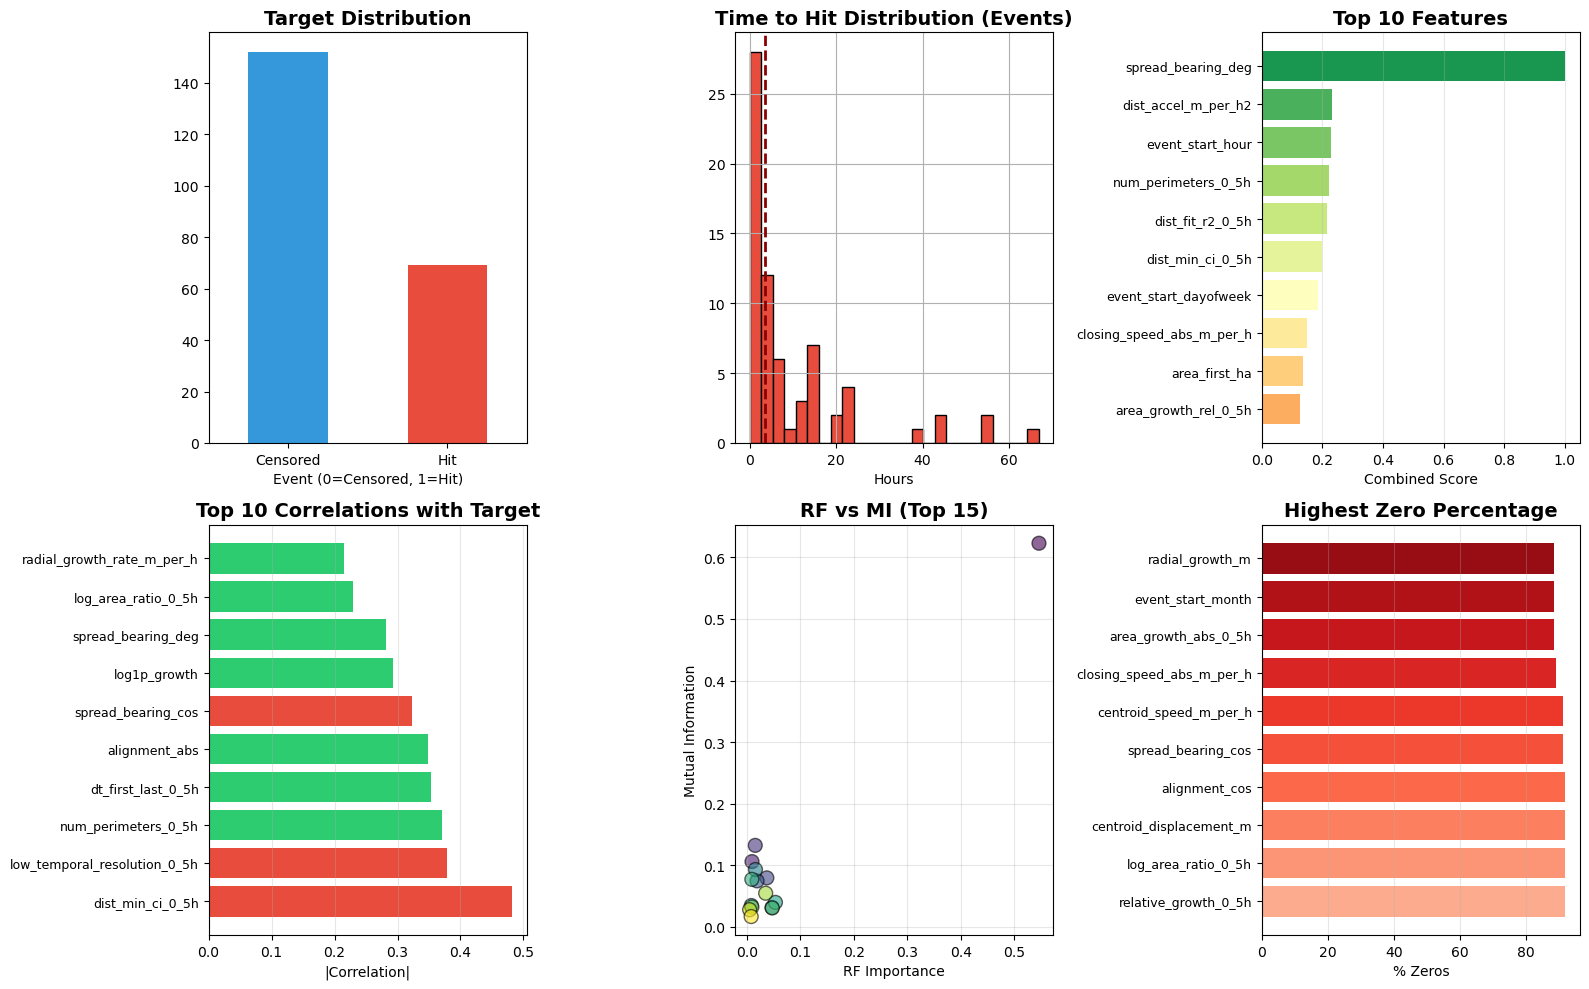

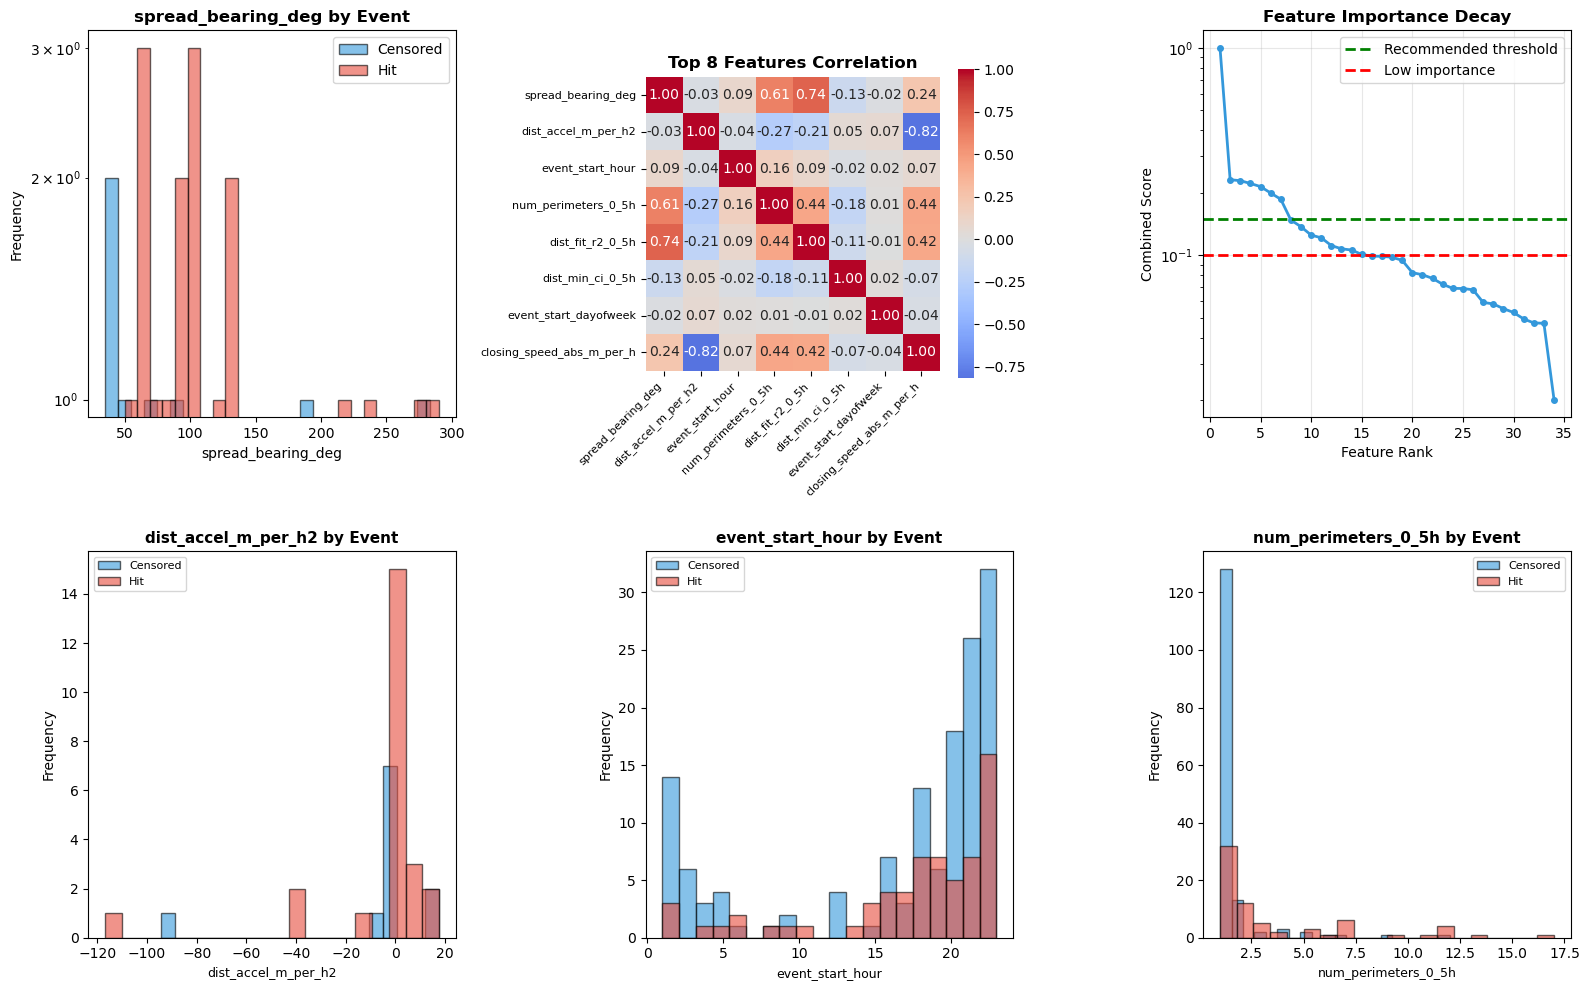

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"\n{'='*80}")
print("CREATING VISUALIZATIONS")
print(f"{'='*80}")

# Figure 1: Overview
fig1 = plt.figure(figsize=(16, 10))

# 1. Target distribution
ax1 = plt.subplot(2, 3, 1)
train[target].value_counts().plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
ax1.set_title('Target Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Event (0=Censored, 1=Hit)')
ax1.set_xticklabels(['Censored', 'Hit'], rotation=0)

# 2. Time distribution
ax2 = plt.subplot(2, 3, 2)
train[train[target]==1][time_target].hist(bins=25, ax=ax2, color='#e74c3c', edgecolor='black')
ax2.set_title('Time to Hit Distribution (Events)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hours')
ax2.axvline(train[train[target]==1][time_target].median(), color='darkred', linestyle='--', lw=2)

# 3. Top features
ax3 = plt.subplot(2, 3, 3)
top_10 = feature_scores.head(10).sort_values('combined_score')
ax3.barh(range(len(top_10)), top_10['combined_score'], color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_10))))
ax3.set_yticks(range(len(top_10)))
ax3.set_yticklabels(top_10['feature'], fontsize=9)
ax3.set_xlabel('Combined Score')
ax3.set_title('Top 10 Features', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

# 4. Correlation with target
ax4 = plt.subplot(2, 3, 4)
top_corr = correlations_sorted.head(10)
colors = ['#2ecc71' if correlations[f] > 0 else '#e74c3c' for f in top_corr.index]
ax4.barh(range(len(top_corr)), top_corr.values, color=colors)
ax4.set_yticks(range(len(top_corr)))
ax4.set_yticklabels(top_corr.index, fontsize=9)
ax4.set_xlabel('|Correlation|')
ax4.set_title('Top 10 Correlations with Target', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3, axis='x')

# 5. Feature importance comparison
ax5 = plt.subplot(2, 3, 5)
top_15 = feature_scores.head(15)
ax5.scatter(top_15['rf_importance'], top_15['mi_score'], s=100, alpha=0.6, 
           c=range(len(top_15)), cmap='viridis', edgecolors='black')
ax5.set_xlabel('RF Importance')
ax5.set_ylabel('Mutual Information')
ax5.set_title('RF vs MI (Top 15)', fontsize=14, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Zero percentage
ax6 = plt.subplot(2, 3, 6)
zero_top = feature_scores.sort_values('zeros_pct', ascending=False).head(10)
ax6.barh(range(len(zero_top)), zero_top['zeros_pct'], 
        color=plt.cm.Reds(np.linspace(0.3, 0.9, len(zero_top))))
ax6.set_yticks(range(len(zero_top)))
ax6.set_yticklabels(zero_top['feature'], fontsize=9)
ax6.set_xlabel('% Zeros')
ax6.set_title('Highest Zero Percentage', fontsize=14, fontweight='bold')
ax6.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_overview.png")

# Figure 2: Detailed feature analysis
fig2 = plt.figure(figsize=(16, 10))

# 1. Most important feature distribution
ax1 = plt.subplot(2, 3, 1)
most_imp = feature_scores.iloc[0]['feature']
for event_val, color, label in [(0, '#3498db', 'Censored'), (1, '#e74c3c', 'Hit')]:
    data = train[train[target] == event_val][most_imp]
    if (data > 0).sum() > 0:
        ax1.hist(data[data > 0], bins=25, alpha=0.6, label=label, color=color, edgecolor='black')
ax1.set_xlabel(most_imp, fontsize=10)
ax1.set_ylabel('Frequency')
ax1.set_title(f'{most_imp} by Event', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_yscale('log')

# 2. Correlation heatmap (top features)
ax2 = plt.subplot(2, 3, 2)
top_feats = feature_scores.head(8)['feature'].tolist()
corr_subset = train[top_feats].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Top 8 Features Correlation', fontsize=12, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=8)

# 3. Feature importance decay
ax3 = plt.subplot(2, 3, 3)
ax3.plot(range(1, len(feature_scores)+1), feature_scores['combined_score'].values, 
        marker='o', linewidth=2, markersize=4, color='#3498db')
ax3.axhline(y=0.15, color='g', linestyle='--', lw=2, label='Recommended threshold')
ax3.axhline(y=0.1, color='r', linestyle='--', lw=2, label='Low importance')
ax3.set_xlabel('Feature Rank')
ax3.set_ylabel('Combined Score')
ax3.set_title('Feature Importance Decay', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(alpha=0.3)
ax3.legend()

# 4-6. Distribution of next important features
for idx in range(3):
    ax = plt.subplot(2, 3, 4 + idx)
    if idx + 1 < len(feature_scores):
        feat = feature_scores.iloc[idx + 1]['feature']
        for event_val, color, label in [(0, '#3498db', 'Censored'), (1, '#e74c3c', 'Hit')]:
            data = train[train[target] == event_val][feat]
            if (data != 0).sum() > 5:
                ax.hist(data[data != 0], bins=20, alpha=0.6, label=label, color=color, edgecolor='black')
        ax.set_xlabel(feat[:30], fontsize=9)
        ax.set_ylabel('Frequency')
        ax.set_title(f'{feat[:30]} by Event', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('eda_features.png', dpi=300, bbox_inches='tight')

## Exploring Findings

### Data quality / Temporal Resolution

In [19]:
# quick stats on variable
from scipy.stats import chi2_contingency, ttest_ind

high_res = train[train['low_temporal_resolution_0_5h'] == 0]
low_res = train[train['low_temporal_resolution_0_5h'] == 1]

print(f"High Res hit rate: {(high_res['event']==1).mean()*100:.1f}%")
print(f"Low Res hit rate:  {(low_res['event']==1).mean()*100:.1f}%")
print(f"High Res avg distance: {high_res['dist_min_ci_0_5h'].mean():,.0f}m")
print(f"Low Res avg distance:  {low_res['dist_min_ci_0_5h'].mean():,.0f}m")

# Chi-square test
ct = np.array([
    [(high_res['event']==0).sum(), (high_res['event']==1).sum()],
    [(low_res['event']==0).sum(), (low_res['event']==1).sum()]
])
chi2, p_value, _, _ = chi2_contingency(ct)
print(f"\nChi-square p-value: {p_value:.6f}")

# Distance difference test
_, dist_p = ttest_ind(high_res['dist_min_ci_0_5h'], low_res['dist_min_ci_0_5h'])
print(f"Distance difference p-value: {dist_p:.6f}")

High Res hit rate: 60.0%
Low Res hit rate:  20.5%
High Res avg distance: 56,652m
Low Res avg distance:  149,647m

Chi-square p-value: 0.000000
Distance difference p-value: 0.000282


Though signifigant p-value, distance triples with low res likely indicating a counfounding variable 

In [20]:
# Stratified Check
train['dist_quartile'] = pd.qcut(train['dist_min_ci_0_5h'], q=4, 
                                  labels=['Q1', 'Q2', 'Q3', 'Q4'])

for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    q_data = train[train['dist_quartile'] == q]
    q_high = q_data[q_data['low_temporal_resolution_0_5h'] == 0]
    q_low = q_data[q_data['low_temporal_resolution_0_5h'] == 1]
    
    hr = (q_high['event']==1).mean()*100 if len(q_high) > 0 else 0
    lr = (q_low['event']==1).mean()*100 if len(q_low) > 0 else 0
    
    print(f"{q}: High={hr:.0f}%, Low={lr:.0f}%")

Q1: High=100%, Low=100%
Q2: High=35%, Low=17%
Q3: High=0%, Low=0%
Q4: High=0%, Low=0%


In [21]:
# Interaction feature 
train['dist_x_temporal'] = (
    train['dist_min_ci_0_5h'] * 
    train['low_temporal_resolution_0_5h']
)

print("Feature correlations with target:")
print(f"  dist_min_ci_0_5h:        {train['dist_min_ci_0_5h'].corr(train['event']):.3f}")
print(f"  low_temporal_resolution: {train['low_temporal_resolution_0_5h'].corr(train['event']):.3f}")
print(f"  dist_x_temporal:         {train['dist_x_temporal'].corr(train['event']):.3f}")

Feature correlations with target:
  dist_min_ci_0_5h:        -0.481
  low_temporal_resolution: -0.379
  dist_x_temporal:         -0.437


Due to importance of distance, interaction feature provides no higher correlation and 